# Introduction



---



---



In this notebook, we will implement the following tests:



For each scaling on alpha:




a) For each epsilon:

- Compute exact $u(x)$
- Compute Hessian M, take $\alpha_{hat} = \epsilon^{-3/4}$ (for $m=0$) or $\alpha_{hat} = \epsilon^{-5/4}$ (for $m=1$)
- Perform a mesh solve
- Perform a physical solve just to compute the L2 or H1 error
- Continuation in $x$

b) Save L2 or H1 error at final epsilon.





Plot Error vs. Scaling.





# Where Do These Scalings Come From?


---



---



I will work it out in the L2 case and leave the H1 case for the reader (lol).


## Step 1 - From my "Exploring_M_and_Epsilon_Relationship" notebook:





- This notebook shows us that the L1 norm of $|u''|$ behaves like $\frac{1}{\epsilon}.$ Thus, $|u''|$ behaves like $\frac{1}{\epsilon^2}.$

- To see this, note that the L1 norm of $|u''|$ is $$ \text{L1 Norm} = \text{width} \times |u''|  \approx \frac{1}{\epsilon}.$$
$$ (\text{width} = \epsilon)  \times |u''|  \approx \frac{1}{\epsilon}.$$
For this to be true, $$ | u'' | \approx \frac{1}{\epsilon^2}.$$


## Step 2 - The Scaling on $|u''|$ in $M$





In the L2 case, I formulate $M$ as $M = ( 1 + \frac{1}{\alpha} |u''| )^{4/5}.$ We want the integral of $M$ to be $O(1).$ Thus, we want
$$ \text{width} = \epsilon \times M \approx 1$$
or
$$ M \approx \epsilon^{-1}.$$

Based on Step 1, we have

$$ \left(\frac{1}{\alpha} |u''| \right)^{4/5} \approx \epsilon^{-1} $$
$$ \left(\frac{1}{\alpha} \epsilon^{-2} \right)^{4/5} \approx \epsilon^{-1} $$
$$ \left(\frac{1}{\alpha} \epsilon^{-2} \right) \approx \epsilon^{-5/4} $$
$$ \left(\frac{1}{\alpha}\right) \approx \epsilon^{-5/4} \epsilon^{2} = \epsilon^{3/4}.$$

Thus, we take

$$ \alpha = \text{constant} \times \epsilon^{-3/4}.$$

# Results and Comments


---



---


- I am not yet using the HR alpha choices in my code yet. I am just picking a (1/alpha) scaling of $|u''|$ in the HR Mesh Density Function.

- Not doing a MP-Iteration here. I am doing a nonlinear mesh solve fueled by the exact solution. I compute a physical solution on the resulting mesh to compute the desired error norms.

- The scalings may improve upon the epsilon-dependent alpha choice.

- It seems like alpha_scale = 5 is best for the L2 case and alpha_scale = 1 or 5 is best for the H1 case?

- Our meshes tend towards uniform meshes as we increase the alpha scaling, as we would expect.

- The H1 errors seem quite large for all epsilons. This makes sense because $u'$ scales like $1/\epsilon$ over regions of length $\epsilon$, so you expect $O(1)$ values for the H1 error.

- The L2 errors seem ok for larger epsilon (1e-5) but get worse as epsilon decreases.

- Not sure if the Error vs. Alpha Scaling plots give any intuition on how we should choose the alpha scaling going forward.

In [ ]:
# install firedrake

# hide output
%%capture

try:
    from firedrake import *
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/firedrake-install-release-real.sh" -O "/tmp/firedrake-install.sh" && bash "/tmp/firedrake-install.sh"
    from firedrake import *

In [ ]:
# Code in this cell makes plots appear an appropriate size and resolution in the browser window

%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (11, 6)

In [ ]:
# import firedrake tools

from firedrake import *
import numpy as np
import matplotlib.pyplot as plt # firedrake makes use of matplotlib tools
from firedrake.pyplot import tripcolor, tricontour, triplot #firedrake plotting
from IPython.display import display
from mpl_toolkits import mplot3d



# Setup

In [ ]:
# SETUP

# Mesh and space
N = 50
xi_mesh = UnitIntervalMesh(N)
V = FunctionSpace(xi_mesh, 'CG', 2)
x = Function(V).interpolate(SpatialCoordinate(xi_mesh)[0])
perm_x =  np.argsort(x.dat.data[:])



# Solver paramaters


newton_params = {
        'snes_type': 'newtonls',
        # 'snes_monitor': None,
        # "snes_converged_reason": None,
        'ksp_type': 'preonly',
        'snes_linesearch_type': 'l2',
        # 'snes_linesearch_monitor': None,
        # 'snes_linesearch_damping': 0.5,
        'pc_type' : 'lu',
        'snes_rtol': 1e-8,
        'snes_stol': 1e-8,
        'snes_max_it': 100,
}


lu_params = {
    'snes_type': 'ksponly',
    # 'snes_monitor': None,
    'mat_type': 'aij',
    'ksp_type': 'preonly',
    'pc_type': 'lu',
}

# Scaling Tests for L2 Norm

_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-


Alpha Scale =  1

_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-


Epsilon =  0.1 :  L2 error is 1.526029768232006e-05



Epsilon =  0.07500000000000001 :  L2 error is 3.6922353320435765e-05



Epsilon =  0.05625000000000001 :  L2 error is 5.3599713140563366e-05



Epsilon =  0.0421875 :  L2 error is 6.694422916925474e-05



Epsilon =  0.031640625000000006 :  L2 error is 0.0001119211412835804



Epsilon =  0.023730468750000004 :  L2 error is 0.00012707368559543257



Epsilon =  0.0177978515625 :  L2 error is 0.00016353848510563656

Epsilon =  0.013348388671875001 :  L2 error is 0.0002572742404337544



Epsilon =  0.01001129150390625 :  L2 error is 0.00030271793763115494



Epsilon =  0.007508468627929688 :  L2 error is 0.0003738095288337491



Epsilon =  0.005631351470947266 :  L2 error is 0.0005445786345430624

Epsilon =  0.004223513603210449 :  L2 error is 0.0007873656101868842



Epsilon =  0.0031676352024078373 :  L2 error is 0.0010009230785563694



Epsilon =  0.002375726401805878 :  L2 error is 0.001191247950618894

Epsilon =  0.0017817948013544084 :  L2 error is 0.001373592400890089



Epsilon =  0.0013363461010158064 :  L2 error is 0.0014004908052819385

Epsilon =  0.0010022595757618548 :  L2 error is 0.0011336536282517441



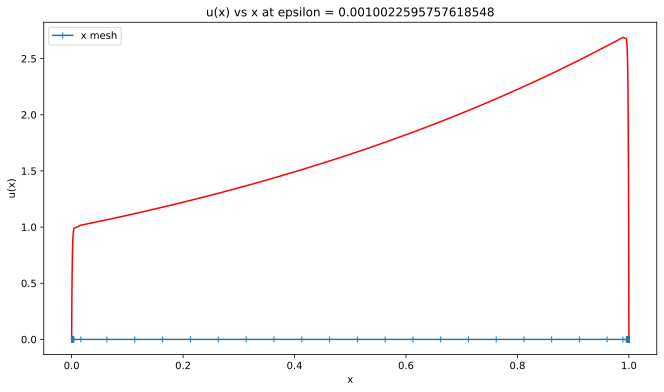

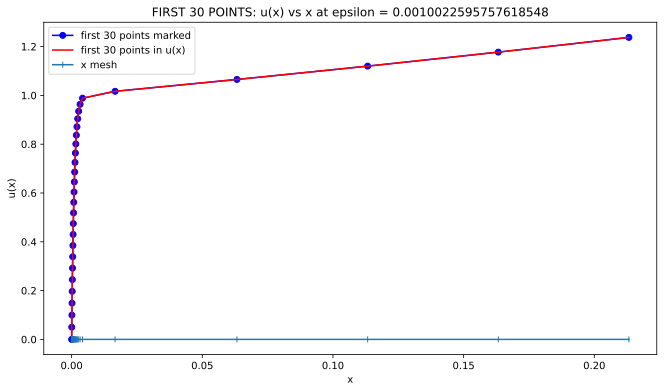

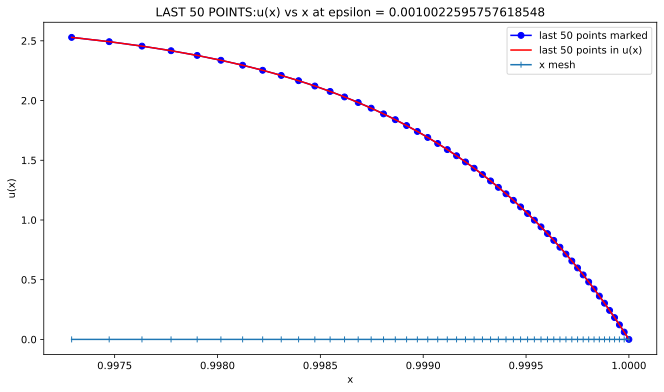



_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-


Alpha Scale =  2.5

_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-




Epsilon =  0.1 :  L2 error is 7.74329005071063e-06



Epsilon =  0.07500000000000001 :  L2 error is 1.39801083157493e-05

Epsilon =  0.05625000000000001 :  L2 error is 2.1217629226255674e-05



Epsilon =  0.0421875 :  L2 error is 3.081651569816176e-05



Epsilon =  0.031640625000000006 :  L2 error is 4.423156303240081e-05



Epsilon =  0.023730468750000004 :  L2 error is 6.12027940413062e-05

Epsilon =  0.0177978515625 :  L2 error is 9.47493351523075e-05



Epsilon =  0.013348388671875001 :  L2 error is 0.00010702794706500325



Epsilon =  0.01001129150390625 :  L2 error is 0.00011764522974669463



Epsilon =  0.007508468627929688 :  L2 error is 0.0001757584470075175

Epsilon =  0.005631351470947266 :  L2 error is 0.00021997737290048772



Epsilon =  0.004223513603210449 :  L2 error is 0.00025887239919640184



Epsilon =  0.0031676352024078373 :  L2 error is 0.0003640290781997109



Epsilon =  0.002375726401805878 :  L2 error is 0.0005451989675065181



Epsilon =  0.0017817948013544084 :  L2 error is 0.0008283351604294307



Epsilon =  0.0013363461010158064 :  L2 error is 0.0012541266227292741

Epsilon =  0.0010022595757618548 :  L2 error is 0.0018377494253549451



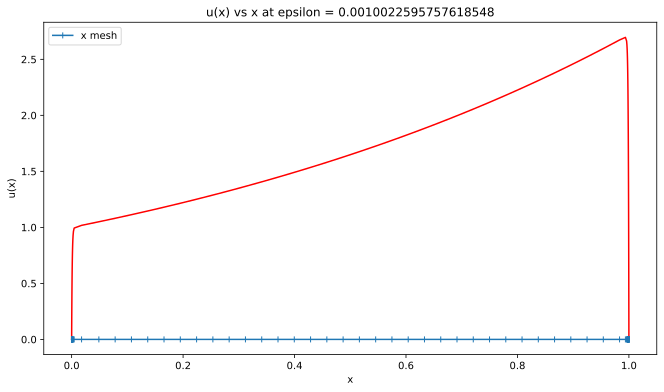

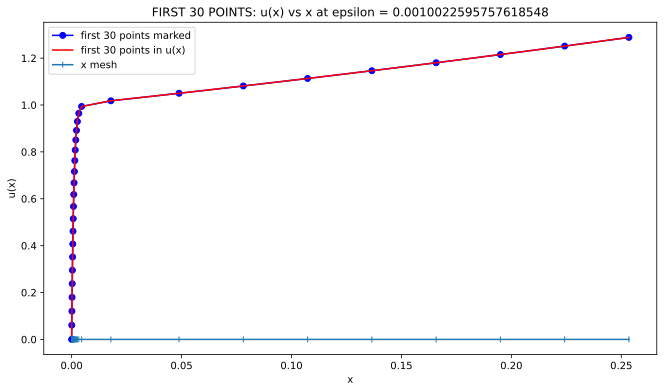

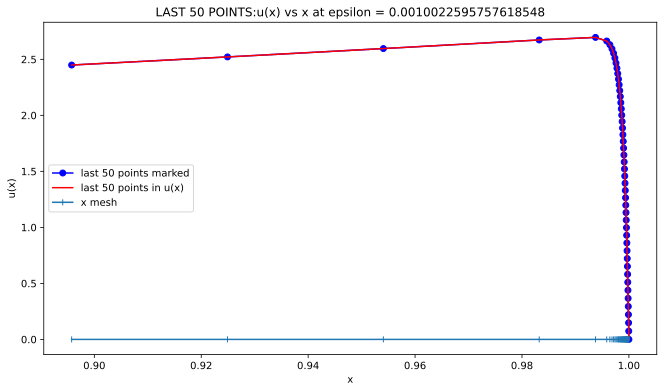



_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-


Alpha Scale =  5

_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-




Epsilon =  0.1 :  L2 error is 5.529099018362437e-06



Epsilon =  0.07500000000000001 :  L2 error is 9.182381600302861e-06

Epsilon =  0.05625000000000001 :  L2 error is 1.4037932230310671e-05



Epsilon =  0.0421875 :  L2 error is 2.0892338694980112e-05



Epsilon =  0.031640625000000006 :  L2 error is 3.064460979994021e-05



Epsilon =  0.023730468750000004 :  L2 error is 4.4371302470727195e-05

Epsilon =  0.0177978515625 :  L2 error is 6.30611397847138e-05



Epsilon =  0.013348388671875001 :  L2 error is 8.997375081471616e-05



Epsilon =  0.01001129150390625 :  L2 error is 0.0001246471623667313



Epsilon =  0.007508468627929688 :  L2 error is 0.00014534079198032893



Epsilon =  0.005631351470947266 :  L2 error is 0.00017673149107361573



Epsilon =  0.004223513603210449 :  L2 error is 0.00020268904685428777



Epsilon =  0.0031676352024078373 :  L2 error is 0.00025733852112198673



Epsilon =  0.002375726401805878 :  L2 error is 0.0003315947443968005



Epsilon =  0.0017817948013544084 :  L2 error is 0.0003693677749691927

Epsilon =  0.0013363461010158064 :  L2 error is 0.0003656970156994689



Epsilon =  0.0010022595757618548 :  L2 error is 0.0003369383507986



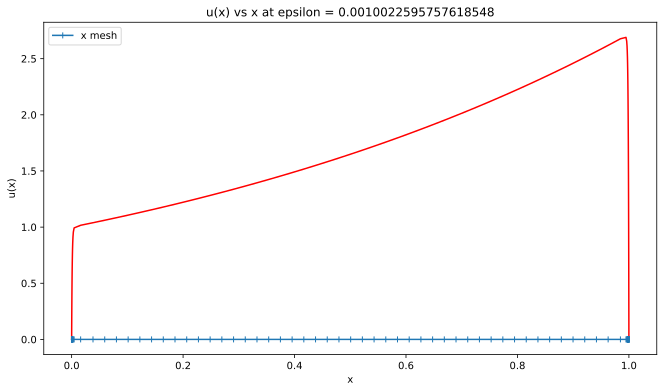

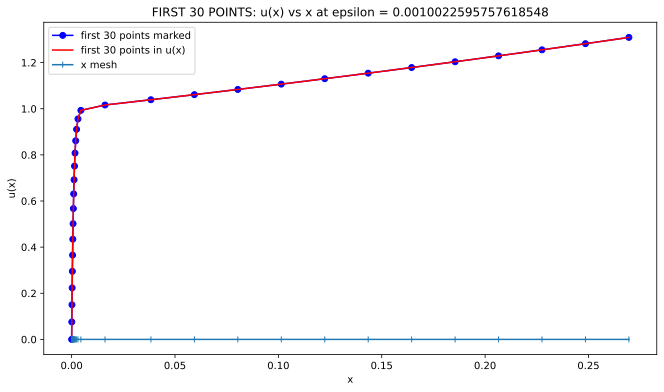

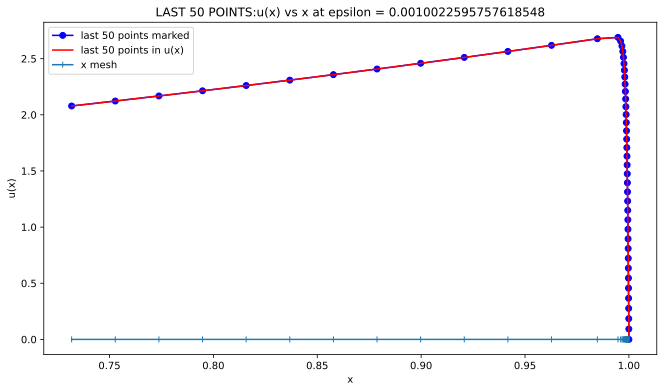



_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-


Alpha Scale =  7.5

_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-




Epsilon =  0.1 :  L2 error is 4.965678851175976e-06



Epsilon =  0.07500000000000001 :  L2 error is 8.108656458366654e-06

Epsilon =  0.05625000000000001 :  L2 error is 1.2508878235986442e-05



Epsilon =  0.0421875 :  L2 error is 1.882222944060976e-05



Epsilon =  0.031640625000000006 :  L2 error is 2.7865709190907807e-05

Epsilon =  0.023730468750000004 :  L2 error is 4.0699240727771136e-05



Epsilon =  0.0177978515625 :  L2 error is 5.913231848763665e-05

Epsilon =  0.013348388671875001 :  L2 error is 7.876630196349503e-05



Epsilon =  0.01001129150390625 :  L2 error is 0.0001075828963347679



Epsilon =  0.007508468627929688 :  L2 error is 0.0001643246368002981



Epsilon =  0.005631351470947266 :  L2 error is 0.00022913634651653

Epsilon =  0.004223513603210449 :  L2 error is 0.0003202729164605888



Epsilon =  0.0031676352024078373 :  L2 error is 0.00040352611420233365



Epsilon =  0.002375726401805878 :  L2 error is 0.0004395303323769117



Epsilon =  0.0017817948013544084 :  L2 error is 0.0004770892691757088



Epsilon =  0.0013363461010158064 :  L2 error is 0.0005718311636047543

Epsilon =  0.0010022595757618548 :  L2 error is 0.000722624498716757



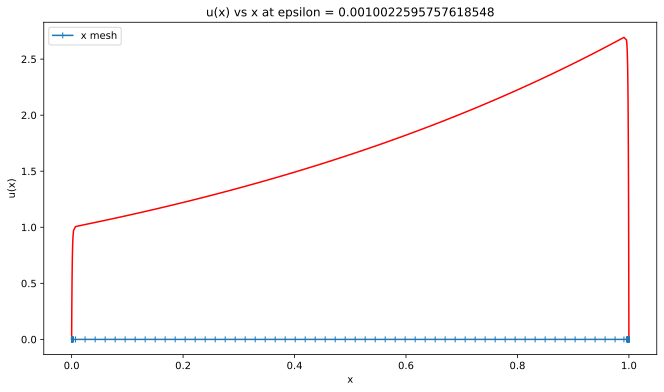

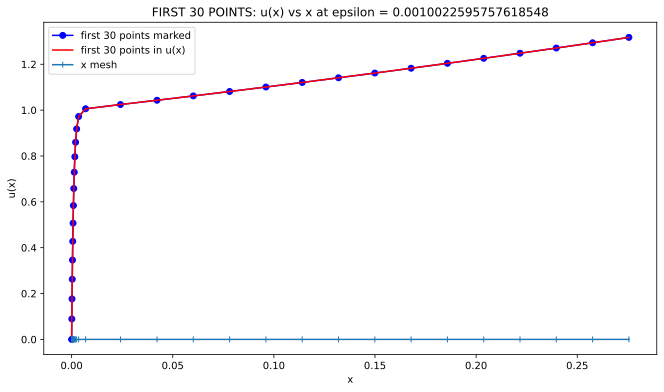

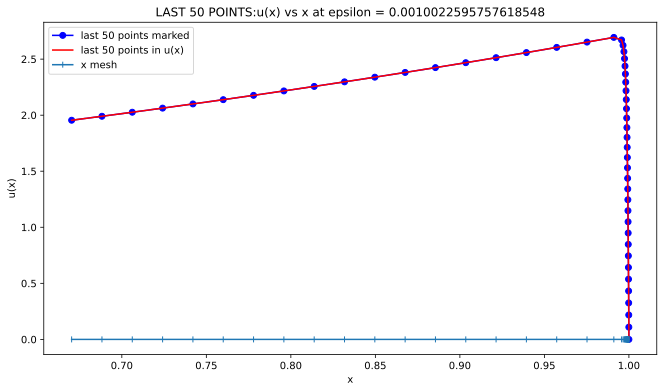



_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-


Alpha Scale =  10

_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-




Epsilon =  0.1 :  L2 error is 4.801527183373278e-06



Epsilon =  0.07500000000000001 :  L2 error is 7.789326163047364e-06



Epsilon =  0.05625000000000001 :  L2 error is 1.211315713870992e-05

Epsilon =  0.0421875 :  L2 error is 1.8390404027390694e-05



Epsilon =  0.031640625000000006 :  L2 error is 2.7421927969186214e-05



Epsilon =  0.023730468750000004 :  L2 error is 4.027453257560885e-05



Epsilon =  0.0177978515625 :  L2 error is 5.867936044578691e-05



Epsilon =  0.013348388671875001 :  L2 error is 8.197674940277793e-05

Epsilon =  0.01001129150390625 :  L2 error is 0.0001076522382485608



Epsilon =  0.007508468627929688 :  L2 error is 0.00015558754665027778



Epsilon =  0.005631351470947266 :  L2 error is 0.00021438605811141388



Epsilon =  0.004223513603210449 :  L2 error is 0.00030680219506543414



Epsilon =  0.0031676352024078373 :  L2 error is 0.00044392984916108604



Epsilon =  0.002375726401805878 :  L2 error is 0.0005452767256528649



Epsilon =  0.0017817948013544084 :  L2 error is 0.0005710982805845661



Epsilon =  0.0013363461010158064 :  L2 error is 0.0005564833884601944

Epsilon =  0.0010022595757618548 :  L2 error is 0.0005436790601977885



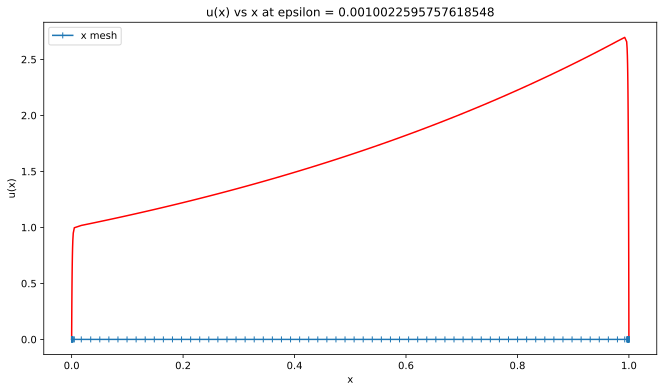

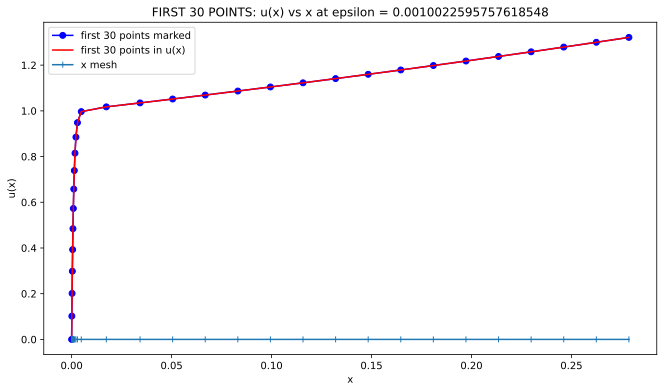

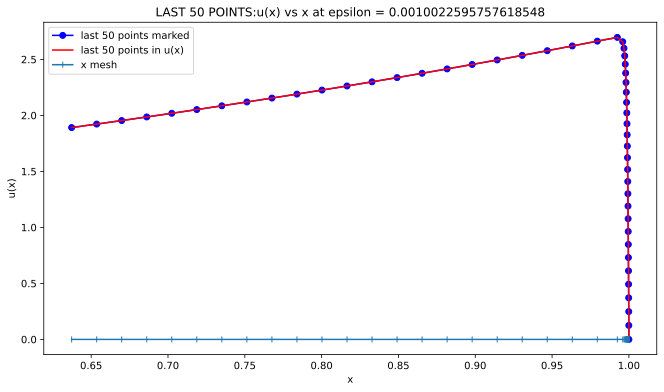



_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-


Alpha Scale =  15

_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-




Epsilon =  0.1 :  L2 error is 4.884926364517106e-06



Epsilon =  0.07500000000000001 :  L2 error is 7.832243305159866e-06



Epsilon =  0.05625000000000001 :  L2 error is 1.2288975420246209e-05



Epsilon =  0.0421875 :  L2 error is 1.892282947034973e-05

Epsilon =  0.031640625000000006 :  L2 error is 2.8569703946589947e-05



Epsilon =  0.023730468750000004 :  L2 error is 4.2370095109446465e-05



Epsilon =  0.0177978515625 :  L2 error is 6.182824217531373e-05



Epsilon =  0.013348388671875001 :  L2 error is 8.898053067205525e-05

Epsilon =  0.01001129150390625 :  L2 error is 0.0001197817563770347



Epsilon =  0.007508468627929688 :  L2 error is 0.00015245637151352687



Epsilon =  0.005631351470947266 :  L2 error is 0.00022227669294923495

Epsilon =  0.004223513603210449 :  L2 error is 0.0003306229744271555



Epsilon =  0.0031676352024078373 :  L2 error is 0.00042294259844443896



Epsilon =  0.002375726401805878 :  L2 error is 0.00048635595858540165



Epsilon =  0.0017817948013544084 :  L2 error is 0.0005950002049653901

Epsilon =  0.0013363461010158064 :  L2 error is 0.0007944678740789691



Epsilon =  0.0010022595757618548 :  L2 error is 0.0010755794690370283



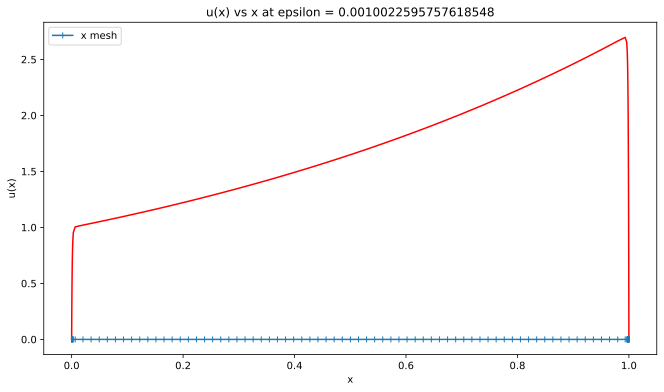

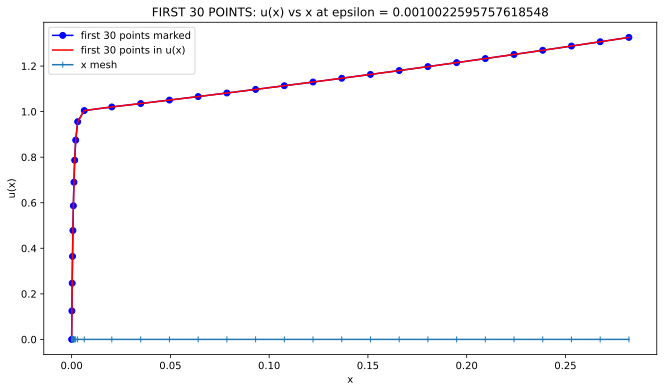

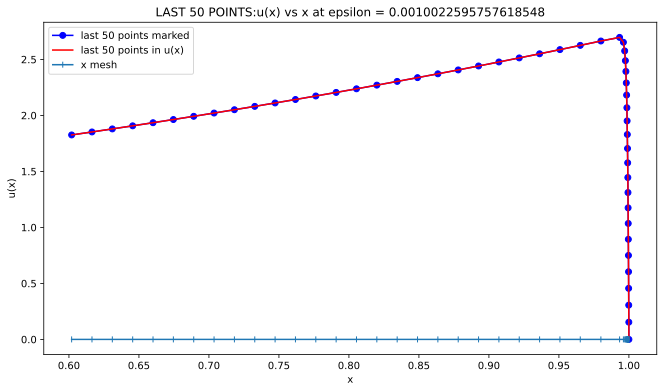



_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-


Alpha Scale =  20

_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-




Epsilon =  0.1 :  L2 error is 5.186370732724726e-06



Epsilon =  0.07500000000000001 :  L2 error is 8.21171541706722e-06



Epsilon =  0.05625000000000001 :  L2 error is 1.2891224858631727e-05

Epsilon =  0.0421875 :  L2 error is 2.0016709514606416e-05



Epsilon =  0.031640625000000006 :  L2 error is 3.0539829807440596e-05



Epsilon =  0.023730468750000004 :  L2 error is 4.569461383090629e-05



Epsilon =  0.0177978515625 :  L2 error is 6.715624584459004e-05



Epsilon =  0.013348388671875001 :  L2 error is 9.691380125368509e-05



Epsilon =  0.01001129150390625 :  L2 error is 0.00013857103346879443



Epsilon =  0.007508468627929688 :  L2 error is 0.0001829632247705091



Epsilon =  0.005631351470947266 :  L2 error is 0.00021753660453312606



Epsilon =  0.004223513603210449 :  L2 error is 0.0002740784570109233

Epsilon =  0.0031676352024078373 :  L2 error is 0.00035269996055064943



Epsilon =  0.002375726401805878 :  L2 error is 0.00044757102579868335



Epsilon =  0.0017817948013544084 :  L2 error is 0.0005529631063070712



Epsilon =  0.0013363461010158064 :  L2 error is 0.0006317242614826589

Epsilon =  0.0010022595757618548 :  L2 error is 0.0006641486005370315



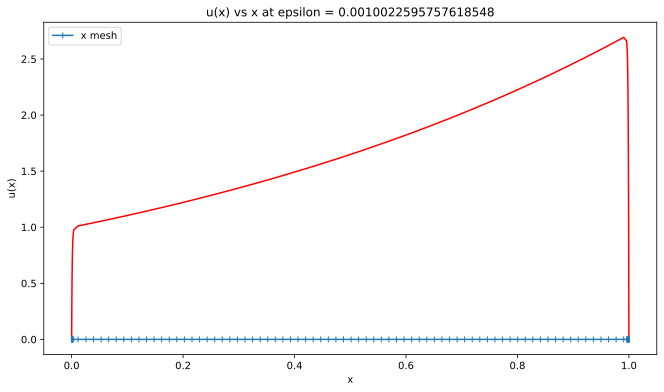

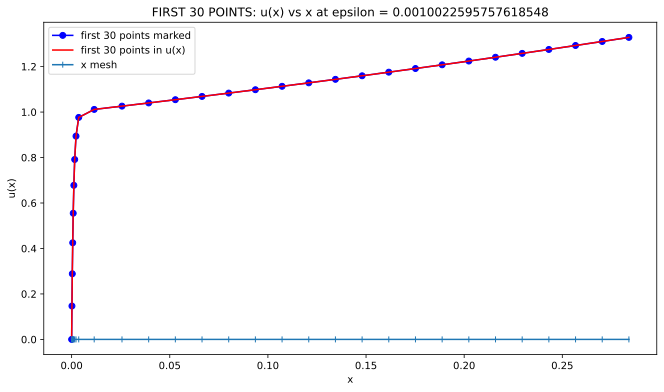

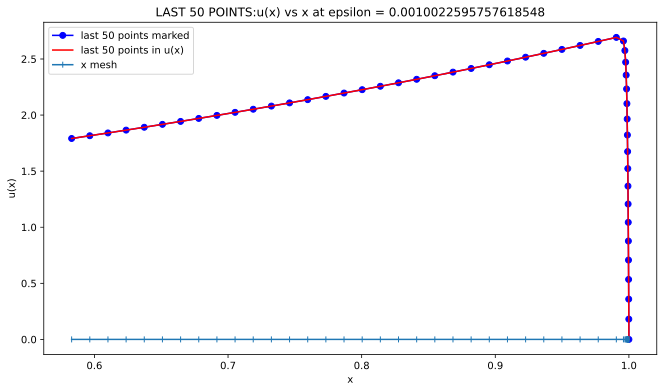



_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-


Alpha Scale =  25

_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-




Epsilon =  0.1 :  L2 error is 5.576176334223402e-06



Epsilon =  0.07500000000000001 :  L2 error is 8.734758060263213e-06



Epsilon =  0.05625000000000001 :  L2 error is 1.3659124444970876e-05

Epsilon =  0.0421875 :  L2 error is 2.1278099819693335e-05



Epsilon =  0.031640625000000006 :  L2 error is 3.271637884731677e-05



Epsilon =  0.023730468750000004 :  L2 error is 4.9353250042336676e-05



Epsilon =  0.0177978515625 :  L2 error is 7.293439254251466e-05

Epsilon =  0.013348388671875001 :  L2 error is 0.0001061113531104399



Epsilon =  0.01001129150390625 :  L2 error is 0.00015522295137429515



Epsilon =  0.007508468627929688 :  L2 error is 0.00021409206268263372



Epsilon =  0.005631351470947266 :  L2 error is 0.00027221439582928846



Epsilon =  0.004223513603210449 :  L2 error is 0.00035266419340428806



Epsilon =  0.0031676352024078373 :  L2 error is 0.000525742568422492



Epsilon =  0.002375726401805878 :  L2 error is 0.0007932830266609394



Epsilon =  0.0017817948013544084 :  L2 error is 0.0010783179666273431



Epsilon =  0.0013363461010158064 :  L2 error is 0.0013458352826376631

Epsilon =  0.0010022595757618548 :  L2 error is 0.0015982953717518106



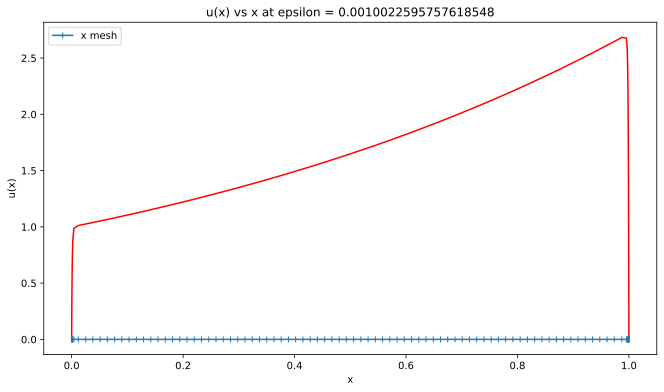

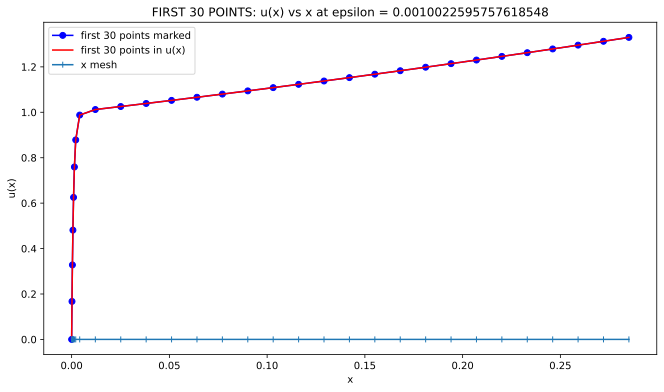

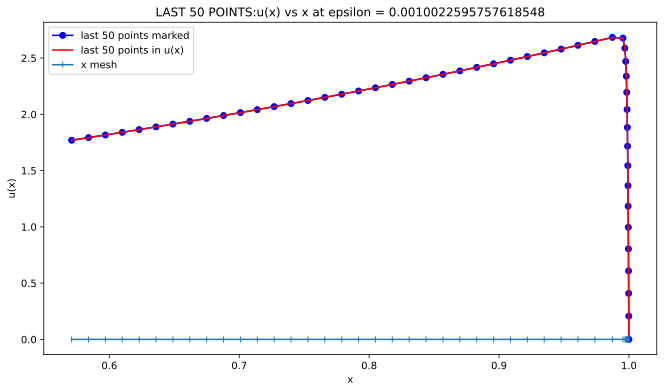



_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-


Alpha Scale =  30

_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-




Epsilon =  0.1 :  L2 error is 6.007227362471848e-06



Epsilon =  0.07500000000000001 :  L2 error is 9.332703674395015e-06



Epsilon =  0.05625000000000001 :  L2 error is 1.4517627502939518e-05

Epsilon =  0.0421875 :  L2 error is 2.260941373268907e-05



Epsilon =  0.031640625000000006 :  L2 error is 3.493425027435042e-05



Epsilon =  0.023730468750000004 :  L2 error is 5.307059453825714e-05



Epsilon =  0.0177978515625 :  L2 error is 7.89841292501281e-05



Epsilon =  0.013348388671875001 :  L2 error is 0.00011545794905314011



Epsilon =  0.01001129150390625 :  L2 error is 0.00016635056546969977



Epsilon =  0.007508468627929688 :  L2 error is 0.00021765187549243204



Epsilon =  0.005631351470947266 :  L2 error is 0.0002507685013195525

Epsilon =  0.004223513603210449 :  L2 error is 0.00029309875889712504



Epsilon =  0.0031676352024078373 :  L2 error is 0.0003668758425414864



Epsilon =  0.002375726401805878 :  L2 error is 0.0005135342350400157



Epsilon =  0.0017817948013544084 :  L2 error is 0.0007007564902956437



Epsilon =  0.0013363461010158064 :  L2 error is 0.0008438904432170338

Epsilon =  0.0010022595757618548 :  L2 error is 0.0009112874086759565



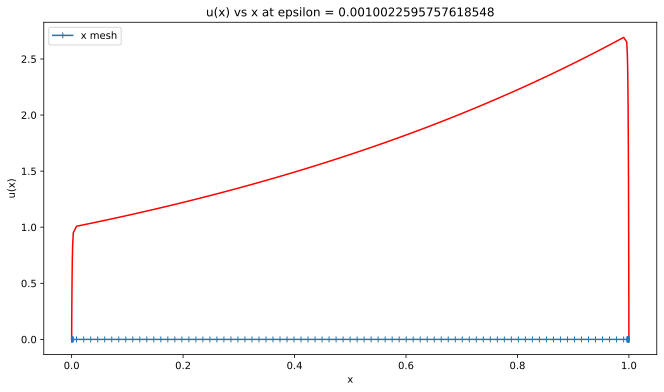

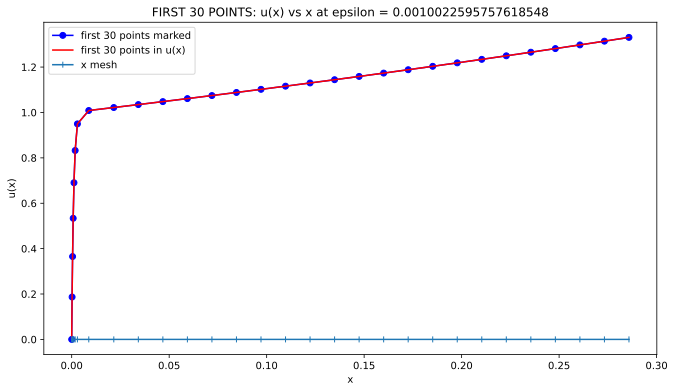

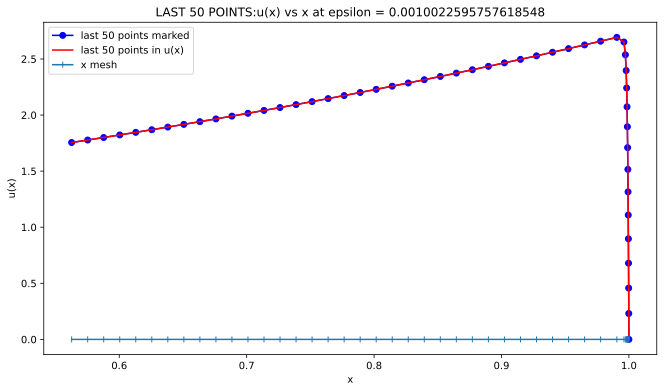



----------------------------------------------------------------------------------------------------

The L2 Error results:

----------------------------------------------------------------------------------------------------


Alpha Scale =  1
L2 Error =  0.0011336536282517441

Alpha Scale =  2.5
L2 Error =  0.0018377494253549451

Alpha Scale =  5
L2 Error =  0.0003369383507986

Alpha Scale =  7.5
L2 Error =  0.000722624498716757

Alpha Scale =  10
L2 Error =  0.0005436790601977885

Alpha Scale =  15
L2 Error =  0.0010755794690370283

Alpha Scale =  20
L2 Error =  0.0006641486005370315

Alpha Scale =  25
L2 Error =  0.0015982953717518106

Alpha Scale =  30
L2 Error =  0.0009112874086759565



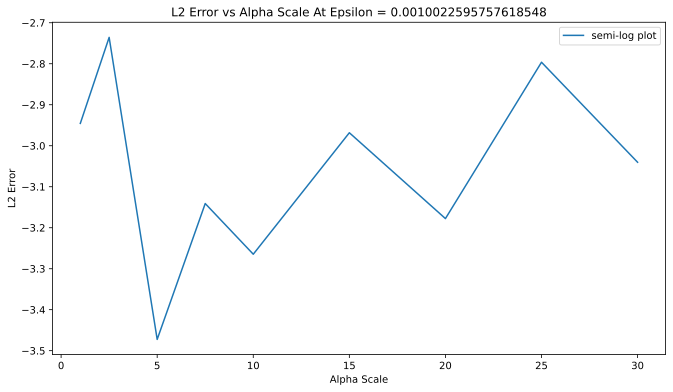

In [ ]:
# Set epsilons
epsilon = 0.1
eps_final = 1e-3
eps_change = 3/4
scales = [1, 2.5 , 5, 7.5, 10, 15, 20, 25, 30]
scale_results_L2 = []
L2_results = []
x_save = Function(V)
u_save = Function(V)

# Set L2 norm minimizing
p = 2
q = 2
m = 0
exp_M = Constant( (2*q) / (1 + q*(2-m)) )
alpha_power = -3/4

# Loop over alpha scales
for alpha_scale in scales:

    print('_-'*100)
    print()
    print()
    print('Alpha Scale = ', alpha_scale)
    print()
    print('_-'*100)
    print()
    print()


    # Re-set x and epsilon at the new scaling
    x = Function(V).interpolate(SpatialCoordinate(xi_mesh)[0])
    epsilon = 0.1


    # Epsilon continuation loop
    while epsilon >= eps_final:


        # NONLINEAR MESH SOLVE


        # set solution and test function
        new_x = Function(V)
        vm = TestFunction(V)


        # jacobian
        Jm = new_x.dx(0) #dx/dxi


        # Compute exact u
        top = (1 - exp(1 - 1/epsilon))*exp(-new_x/epsilon) + (exp(1) - exp(-1/epsilon))*exp((new_x-1)/epsilon)
        bottom = (epsilon**2 - 1) * ( 1 - exp(-2/epsilon) )
        sub = exp(new_x)/(epsilon**2 - 1)
        u_e = top/bottom - sub


        # Compute u'
        upr_f = (1/Jm) * u_e.dx(0)
        # Compute u''
        u_pr_xi = u_e.dx(0)
        u_prpr_xi = u_pr_xi.dx(0)
        x_prpr_xi = Jm.dx(0)
        u_prpr = ( u_prpr_xi -  upr_f * x_prpr_xi) * (( 1/Jm )**2)

        # Compute M
        alpha_hat = alpha_scale * epsilon ** (alpha_power) # OUR ALPHA SCALED WITH EPSILON!!
        # alpha_term1 = float(alpha_hat * sqrt(assemble(u_e*u_e* Jm * dx)))
        M = ( 1 + (1/alpha_hat) * abs(u_prpr) )**exp_M

        # v'
        v_pr_term = (vm).dx(0)

        # the lhs of the eqn
        F = (M * Jm * v_pr_term) * dx

        # bc's
        bc0 = DirichletBC(V, Constant(0), 1)
        bc1 = DirichletBC(V, Constant(1), 2)
        bcs = [bc0, bc1]


        # initial guess
        new_x.dat.data[:] = x.dat.data[:]


        # The actual solve
        try:
          solve( F == 0, new_x, bcs = bcs, solver_parameters=newton_params)
        except Exception as e:
          print('MESH SOLVE FAILED BECAUSE ', e)
          print()
          print()
          forced_break = True
          break


        # update our x
        x.dat.data[:] = new_x.dat.data[:]


        # PHYSICAL SOLVE FOR ERROR CALCULATIONS

        # Test and Trial Functions
        u = TrialFunction(V)
        v = TestFunction(V)

        # Jacobian of x
        Jx = x.dx(0) #dx/dxi

        # Set the bilinear and linear forms of the weak form
        u_deriv = (1/Jx) * u.dx(0) # transform to du/dx
        v_deriv = (1/Jx) * v.dx(0) # transform to dv/dx
        a = ((epsilon**2)* (u_deriv * v_deriv ) + inner(u, v)) * Jx * dx # transform dxi to dx
        L = ( exp(x) ) * v * Jx * dx #transform dxi to dx

        # Set the BC's
        bcs = [DirichletBC(V, Constant(0), 1), DirichletBC(V, Constant(0), 2)]

        # Solve
        try:
          u = Function(V)
          solve( a==L, u, bcs = bcs, solver_parameters = lu_params)
        except Exception as e:
          print('The physical solve failed due to the following message:')
          print(e)
          print()
          break

        # L2 ERROR CALCULATIONS
        error_val = (u - u_e)
        L2_error = norm(error_val * (sqrt(abs(Jx))))
        print("Epsilon = ", epsilon, ":", end = "  ")
        print("L2 error is", L2_error)
        print()


        # Update epsilon
        epsilon = epsilon * eps_change





    # Plot the exact u
    plt.plot(new_x.dat.data[perm_x], Function(V).interpolate(u_e).dat.data[perm_x], color = "red" )
    plt.plot(new_x.dat.data[perm_x], [0 for i in range(len(new_x.dat.data[perm_x]))], marker = "|", label = "x mesh")
    plt.xlabel('x')
    plt.ylabel("u(x)")
    plt.title("u(x) vs x at epsilon = " + str(epsilon/eps_change))
    plt.legend()
    plt.show()
    print()
    print()

    # Plot the first 30 points
    plt.plot(new_x.dat.data[perm_x][:30], Function(V).interpolate(u_e).dat.data[perm_x][:30], marker = "o", color = "blue", label = 'first 30 points marked' )
    plt.plot(new_x.dat.data[perm_x][:30], Function(V).interpolate(u_e).dat.data[perm_x][:30], color = "red", label = 'first 30 points in u(x)' )
    plt.plot(new_x.dat.data[perm_x][:30], [0 for i in range(30)], marker = "|", label = "x mesh")
    plt.xlabel('x')
    plt.ylabel("u(x)")
    plt.title("FIRST 30 POINTS: u(x) vs x at epsilon = " + str(epsilon/eps_change))
    plt.legend()
    plt.show()
    print()
    print()


    # Plot the last 50 points
    plt.plot(new_x.dat.data[perm_x][-50:], Function(V).interpolate(u_e).dat.data[perm_x][-50:], marker = "o", color = "blue", label = 'last 50 points marked' )
    plt.plot(new_x.dat.data[perm_x][-50:], Function(V).interpolate(u_e).dat.data[perm_x][-50:], color = "red", label = 'last 50 points in u(x)' )
    plt.plot(new_x.dat.data[perm_x][-50:], [0 for i in range(50)], marker = "|", label = "x mesh")
    plt.xlabel('x')
    plt.ylabel("u(x)")
    plt.title("LAST 50 POINTS:u(x) vs x at epsilon = " + str(epsilon/eps_change))
    plt.legend()
    plt.show()
    print()
    print()



    # Save the results
    x_save.dat.data[:] = new_x.dat.data[:]
    u_save.dat.data[:] = Function(V).interpolate(u_e).dat.data[:]
    scale_results_L2.append([alpha_scale, x_save, u_save])
    L2_results.append(L2_error)




# Print and plot the L2 Errors

print('-'*100)
print()
print('The L2 Error results:')
print()
print('-'*100)
print()
print()

for i in range(len(scales)):

  print('Alpha Scale = ', scales[i])
  print('L2 Error = ', L2_results[i])
  print()


plt.plot(scales, np.log10(L2_results), label = "semi-log plot")
plt.xlabel('Alpha Scale')
plt.ylabel('L2 Error')
plt.title('L2 Error vs Alpha Scale At Epsilon = ' + str(epsilon/eps_change))
plt.legend()
plt.show()
print()
print()






# Scaling Tests for H1 Norm

_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-


Alpha Scale =  1

_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-




Epsilon =  0.1 :  H1 error is 0.007591569099412305



Epsilon =  0.07500000000000001 :  H1 error is 0.01277649970353072



Epsilon =  0.05625000000000001 :  H1 error is 0.020591406016166953



Epsilon =  0.0421875 :  H1 error is 0.03299285107381424



Epsilon =  0.031640625000000006 :  H1 error is 0.05406610279432901

Epsilon =  0.023730468750000004 :  H1 error is 0.08615594625182466



Epsilon =  0.0177978515625 :  H1 error is 0.13964668667827598



Epsilon =  0.013348388671875001 :  H1 error is 0.22585493938784176

Epsilon =  0.01001129150390625 :  H1 error is 0.41000403683580217



Epsilon =  0.007508468627929688 :  H1 error is 1.1727422700182775

Epsilon =  0.005631351470947266 :  H1 error is 1.2818191344513148



Epsilon =  0.004223513603210449 :  H1 error is 1.6147340852671832



Epsilon =  0.0031676352024078373 :  H1 error is 1.6850940787445177



Epsilon =  0.002375726401805878 :  H1 error is 2.2664491801493707

Epsilon =  0.0017817948013544084 :  H1 error is 2.581731287003754



Epsilon =  0.0013363461010158064 :  H1 error is 5.513446377464141

Epsilon =  0.0010022595757618548 :  H1 error is 3.5649646207861174



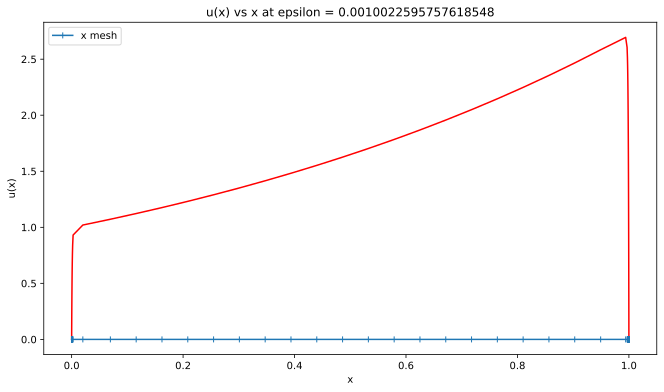

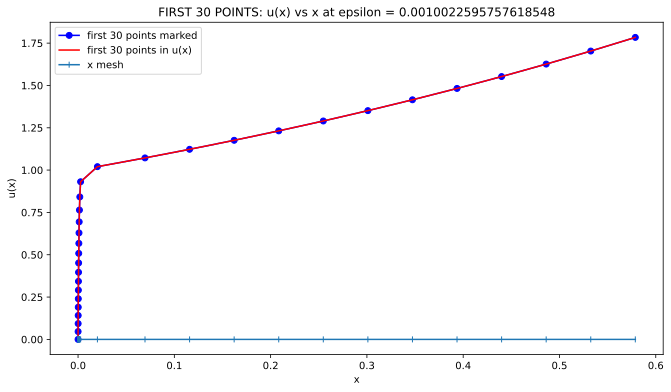

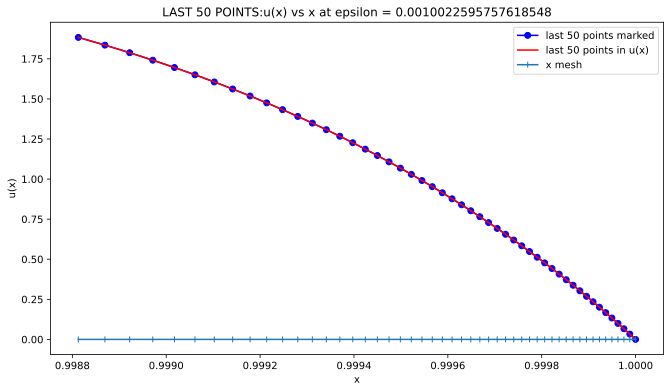



_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-


Alpha Scale =  2.5

_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-


Epsilon =  0.1 :  H1 error is 0.0037196090696323078



Epsilon =  0.07500000000000001 :  H1 error is 0.006226308657740532



Epsilon =  0.05625000000000001 :  H1 error is 0.010231809431690752



Epsilon =  0.0421875 :  H1 error is 0.016678816193662533



Epsilon =  0.031640625000000006 :  H1 error is 0.027090626165557553

Epsilon =  0.023730468750000004 :  H1 error is 0.043967024238697014



Epsilon =  0.0177978515625 :  H1 error is 0.07101902659837178



Epsilon =  0.013348388671875001 :  H1 error is 0.12131123283240923



Epsilon =  0.01001129150390625 :  H1 error is 0.18252041600312502

Epsilon =  0.007508468627929688 :  H1 error is 0.2515709640709169



Epsilon =  0.005631351470947266 :  H1 error is 0.46539262315408025



Epsilon =  0.004223513603210449 :  H1 error is 0.8859715107296456

Epsilon =  0.0031676352024078373 :  H1 error is 2.526906962237313



Epsilon =  0.002375726401805878 :  H1 error is 7.646078115882484



Epsilon =  0.0017817948013544084 :  H1 error is 4.816817733228764



Epsilon =  0.0013363461010158064 :  H1 error is 6.244628530648736

Epsilon =  0.0010022595757618548 :  H1 error is 7.949591034107803



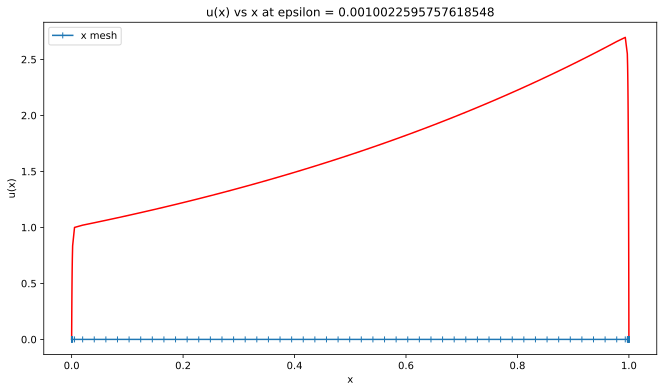

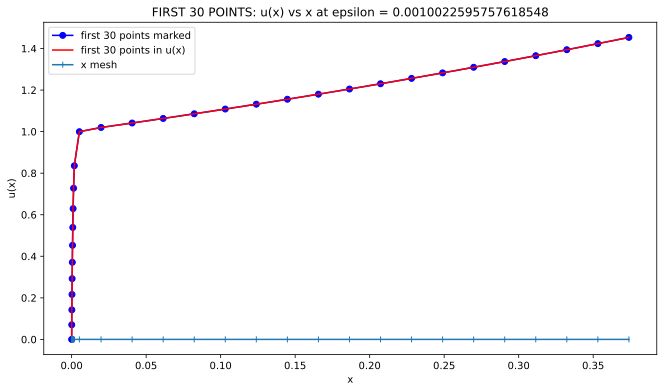

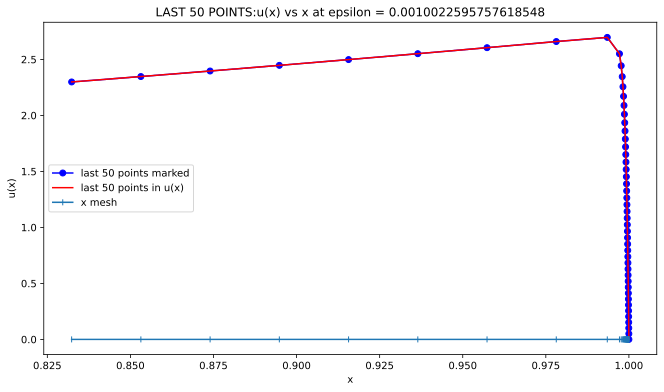



_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-


Alpha Scale =  5

_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-




Epsilon =  0.1 :  H1 error is 0.0028384618669440283



Epsilon =  0.07500000000000001 :  H1 error is 0.004939693537557765



Epsilon =  0.05625000000000001 :  H1 error is 0.008461388150515404



Epsilon =  0.0421875 :  H1 error is 0.014310026727614132

Epsilon =  0.031640625000000006 :  H1 error is 0.023951655513845718



Epsilon =  0.023730468750000004 :  H1 error is 0.03976253175044464



Epsilon =  0.0177978515625 :  H1 error is 0.06567409423854437



Epsilon =  0.013348388671875001 :  H1 error is 0.10842691016350398

Epsilon =  0.01001129150390625 :  H1 error is 0.17283803146532922



Epsilon =  0.007508468627929688 :  H1 error is 0.2832337109071358



Epsilon =  0.005631351470947266 :  H1 error is 0.540813099353103



Epsilon =  0.004223513603210449 :  H1 error is 0.9686272105976381



Epsilon =  0.0031676352024078373 :  H1 error is 1.6647818326046813

Epsilon =  0.002375726401805878 :  H1 error is 3.5579678294417243



Epsilon =  0.0017817948013544084 :  H1 error is 8.084627225252937



Epsilon =  0.0013363461010158064 :  H1 error is 7.201915291361085

Epsilon =  0.0010022595757618548 :  H1 error is 4.549045026349493



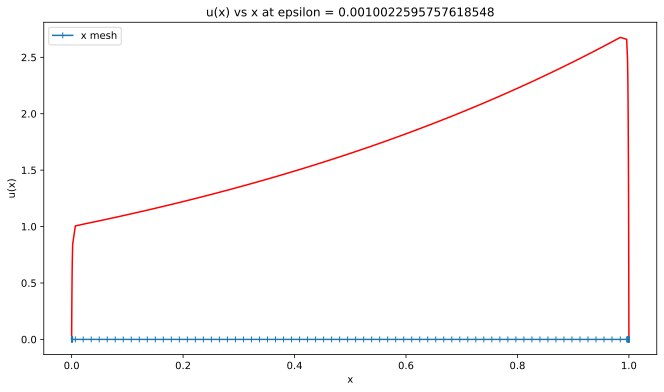

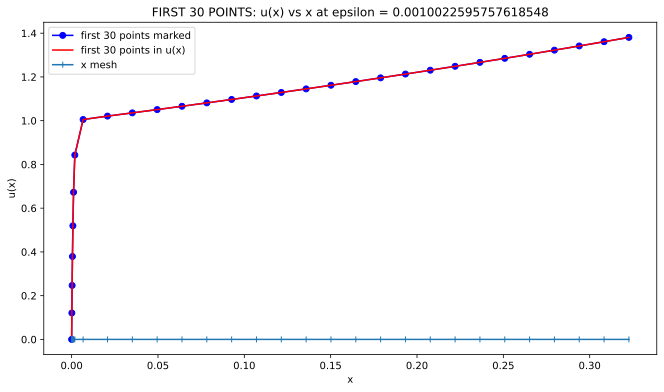

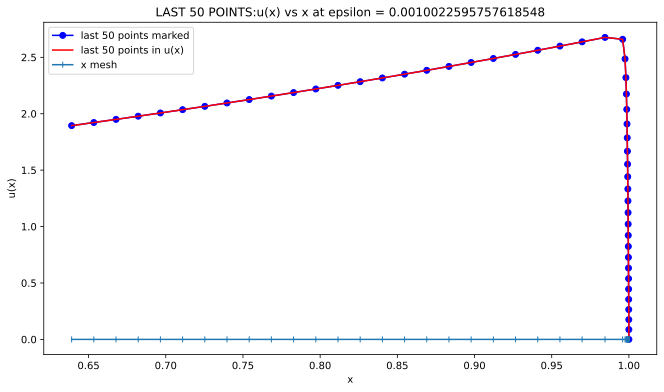

_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-


Alpha Scale =  7.5

_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-


Epsilon =  0.1 :  H1 error is 0.002619879722649173



Epsilon =  0.07500000000000001 :  H1 error is 0.004697281274381733



Epsilon =  0.05625000000000001 :  H1 error is 0.008296936585110768



Epsilon =  0.0421875 :  H1 error is 0.014461746355777154

Epsilon =  0.031640625000000006 :  H1 error is 0.024898106243106927



Epsilon =  0.023730468750000004 :  H1 error is 0.04238003789379678



Epsilon =  0.0177978515625 :  H1 error is 0.07145655345326996



Epsilon =  0.013348388671875001 :  H1 error is 0.11908303912499157

Epsilon =  0.01001129150390625 :  H1 error is 0.1985830786977032



Epsilon =  0.007508468627929688 :  H1 error is 0.3238032609557442



Epsilon =  0.005631351470947266 :  H1 error is 0.5864037662688608



Epsilon =  0.004223513603210449 :  H1 error is 1.0590524634192011



Epsilon =  0.0031676352024078373 :  H1 error is 1.8609075691656183



Epsilon =  0.002375726401805878 :  H1 error is 2.7531064520236246



Epsilon =  0.0017817948013544084 :  H1 error is 2.948661294452057



Epsilon =  0.0013363461010158064 :  H1 error is 3.055460577731647

Epsilon =  0.0010022595757618548 :  H1 error is 4.056083614813797



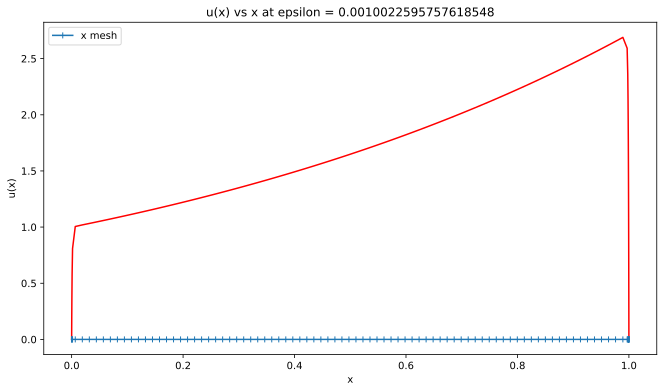

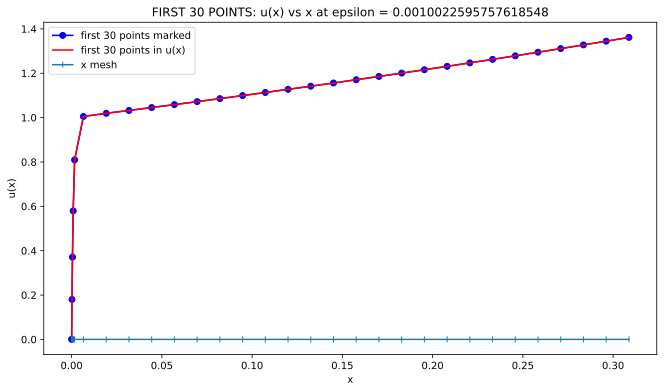

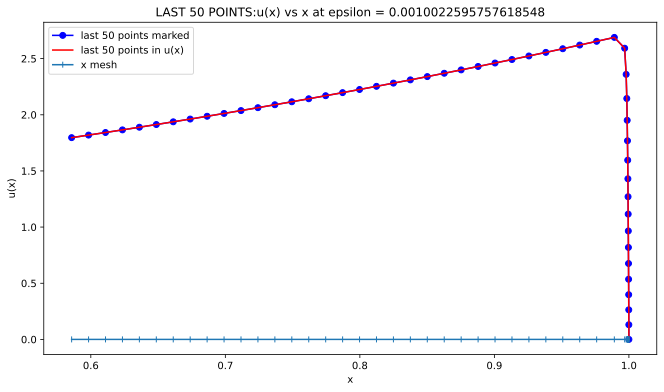



_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-


Alpha Scale =  10

_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-


Epsilon =  0.1 :  H1 error is 0.0025262143503496474



Epsilon =  0.07500000000000001 :  H1 error is 0.004633207678947836



Epsilon =  0.05625000000000001 :  H1 error is 0.008372389730654508



Epsilon =  0.0421875 :  H1 error is 0.014926358878808792



Epsilon =  0.031640625000000006 :  H1 error is 0.026272525980157033



Epsilon =  0.023730468750000004 :  H1 error is 0.04567255398467966



Epsilon =  0.0177978515625 :  H1 error is 0.0784624197656812



Epsilon =  0.013348388671875001 :  H1 error is 0.13367124226048435

Epsilon =  0.01001129150390625 :  H1 error is 0.2236942015185918



Epsilon =  0.007508468627929688 :  H1 error is 0.3596682146408583



Epsilon =  0.005631351470947266 :  H1 error is 0.636415464715092



Epsilon =  0.004223513603210449 :  H1 error is 1.10773520038059

Epsilon =  0.0031676352024078373 :  H1 error is 1.7655193879288984



Epsilon =  0.002375726401805878 :  H1 error is 2.7170812792114387



Epsilon =  0.0017817948013544084 :  H1 error is 8.359308584030233



Epsilon =  0.0013363461010158064 :  H1 error is 53.34941538621604

Epsilon =  0.0010022595757618548 :  H1 error is 13.689273459982841



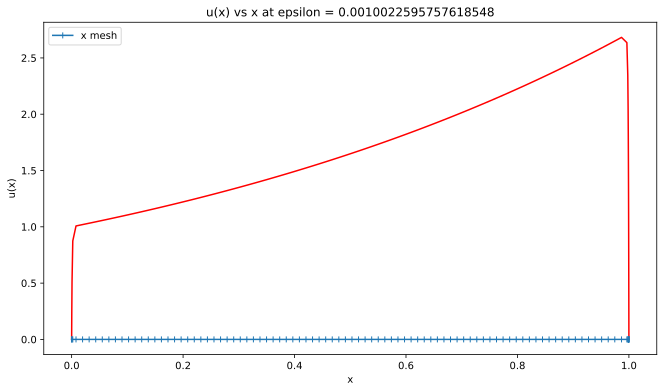

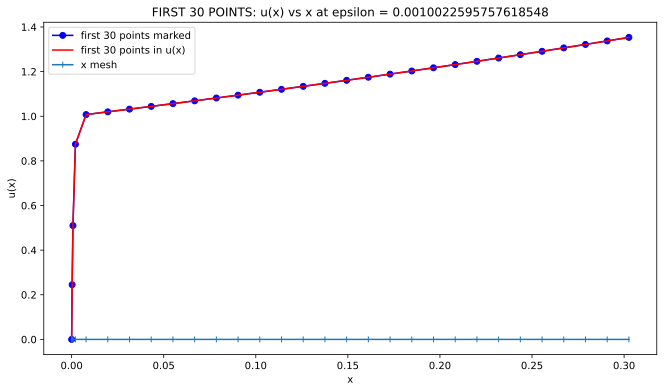

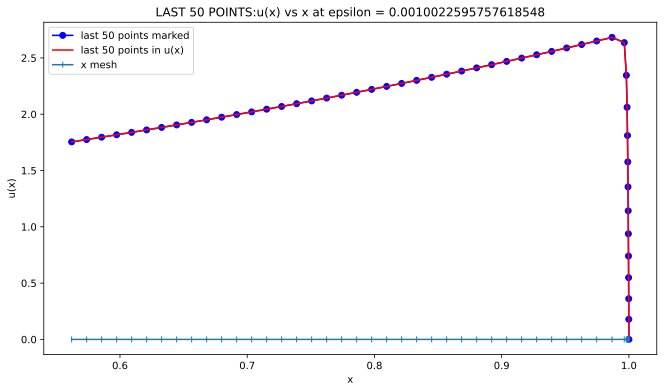



_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-


Alpha Scale =  15

_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-




Epsilon =  0.1 :  H1 error is 0.002444907450397937



Epsilon =  0.07500000000000001 :  H1 error is 0.00460389733123005



Epsilon =  0.05625000000000001 :  H1 error is 0.008590339074134154

Epsilon =  0.0421875 :  H1 error is 0.015823817962336572



Epsilon =  0.031640625000000006 :  H1 error is 0.0287533380219305



Epsilon =  0.023730468750000004 :  H1 error is 0.05156297430708156



Epsilon =  0.0177978515625 :  H1 error is 0.09129165397384634



Epsilon =  0.013348388671875001 :  H1 error is 0.15977213290494588



Epsilon =  0.01001129150390625 :  H1 error is 0.27626088305677804



Epsilon =  0.007508468627929688 :  H1 error is 0.4843265357407404



Epsilon =  0.005631351470947266 :  H1 error is 0.7891655372596901



Epsilon =  0.004223513603210449 :  H1 error is 1.1416165842463206

Epsilon =  0.0031676352024078373 :  H1 error is 1.6410780390482111



Epsilon =  0.002375726401805878 :  H1 error is 2.7903377574088273



Epsilon =  0.0017817948013544084 :  H1 error is 4.881494412509784



Epsilon =  0.0013363461010158064 :  H1 error is 13.841022886098868

Epsilon =  0.0010022595757618548 :  H1 error is 18.144107054984772



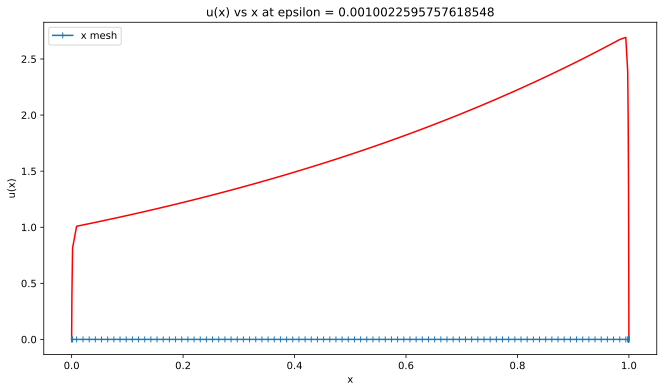

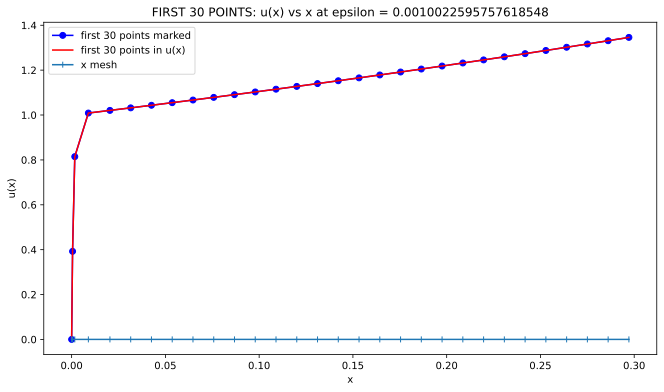

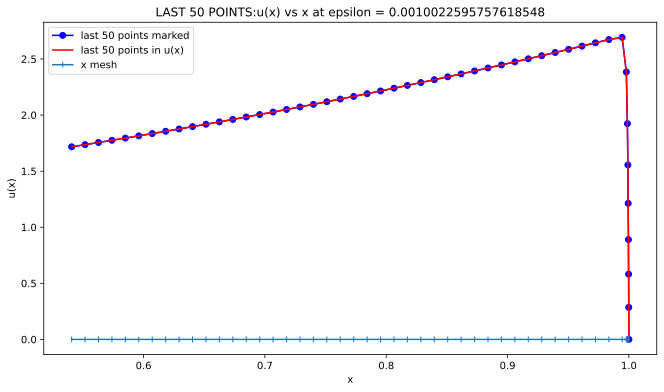



_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-


Alpha Scale =  20

_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-




Epsilon =  0.1 :  H1 error is 0.0024612716475761747



Epsilon =  0.07500000000000001 :  H1 error is 0.004623651376198167



Epsilon =  0.05625000000000001 :  H1 error is 0.008750349261849791

Epsilon =  0.0421875 :  H1 error is 0.016469258583495502



Epsilon =  0.031640625000000006 :  H1 error is 0.030618965566911276



Epsilon =  0.023730468750000004 :  H1 error is 0.05614054222736778



Epsilon =  0.0177978515625 :  H1 error is 0.10157275482501074



Epsilon =  0.013348388671875001 :  H1 error is 0.1811432048867121

Epsilon =  0.01001129150390625 :  H1 error is 0.31956877497456365



Epsilon =  0.007508468627929688 :  H1 error is 0.5570565734024634



Epsilon =  0.005631351470947266 :  H1 error is 0.9197282666666975



Epsilon =  0.004223513603210449 :  H1 error is 1.54550756835404

Epsilon =  0.0031676352024078373 :  H1 error is 2.793930684508146



Epsilon =  0.002375726401805878 :  H1 error is 5.039534384414695



Epsilon =  0.0017817948013544084 :  H1 error is 9.919574365454936



Epsilon =  0.0013363461010158064 :  H1 error is 21.756006712544654

Epsilon =  0.0010022595757618548 :  H1 error is 30.384920075368928



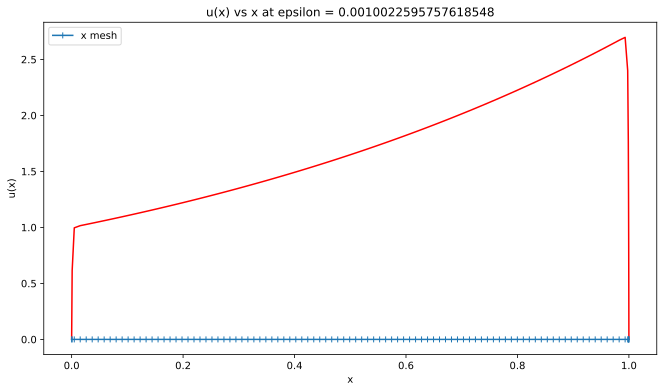

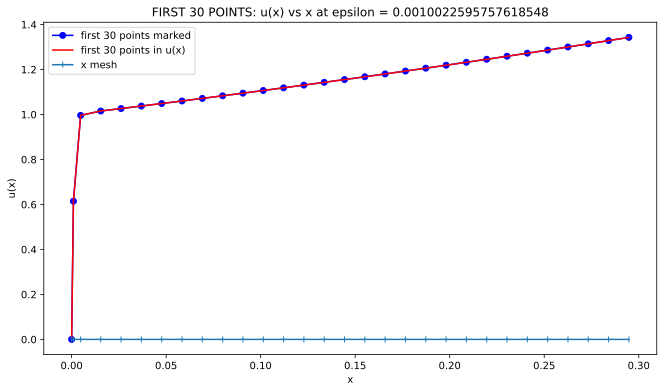

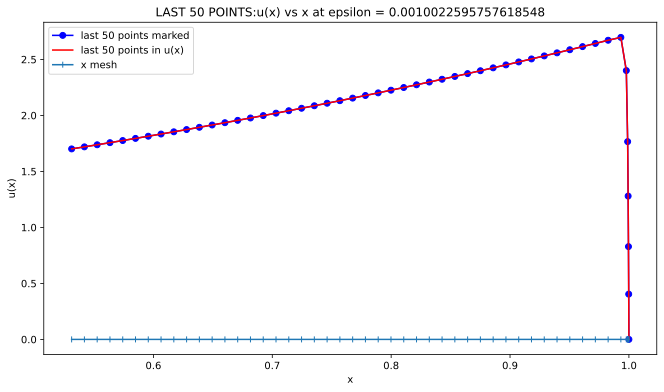



_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-


Alpha Scale =  25

_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-




Epsilon =  0.1 :  H1 error is 0.002576927119832049



Epsilon =  0.07500000000000001 :  H1 error is 0.0047287029342576265



Epsilon =  0.05625000000000001 :  H1 error is 0.008906453253769467



Epsilon =  0.0421875 :  H1 error is 0.016922470145723793



Epsilon =  0.031640625000000006 :  H1 error is 0.0319673568113334



Epsilon =  0.023730468750000004 :  H1 error is 0.059629009708065936



Epsilon =  0.0177978515625 :  H1 error is 0.10968584559112438



Epsilon =  0.013348388671875001 :  H1 error is 0.19904366069179036



Epsilon =  0.01001129150390625 :  H1 error is 0.3569859939120095



Epsilon =  0.007508468627929688 :  H1 error is 0.6591091867877267



Epsilon =  0.005631351470947266 :  H1 error is 1.2156174604061263



Epsilon =  0.004223513603210449 :  H1 error is 2.110179606738474

Epsilon =  0.0031676352024078373 :  H1 error is 3.547730384192778



Epsilon =  0.002375726401805878 :  H1 error is 6.29609468973255



Epsilon =  0.0017817948013544084 :  H1 error is 30.3831423841494



Epsilon =  0.0013363461010158064 :  H1 error is 25.96644824364339

Epsilon =  0.0010022595757618548 :  H1 error is 31.294727800661576



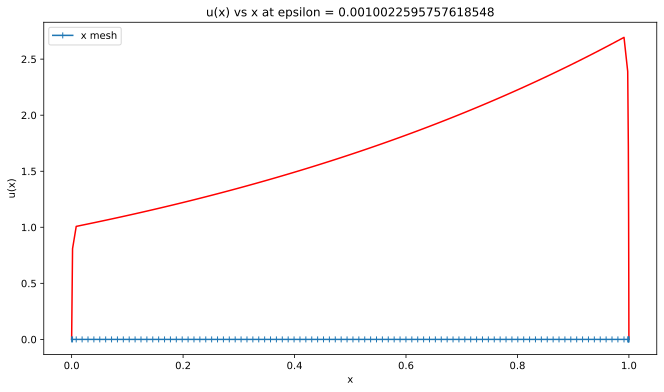

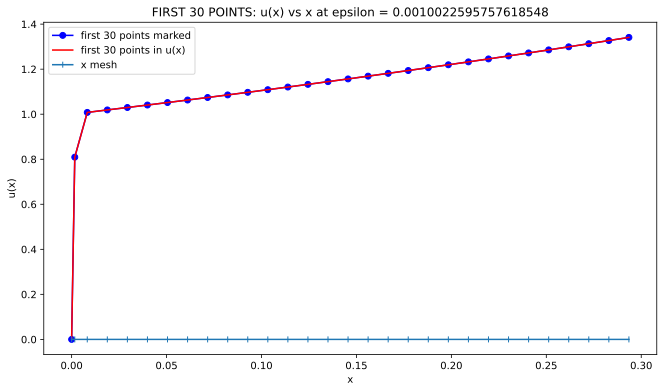

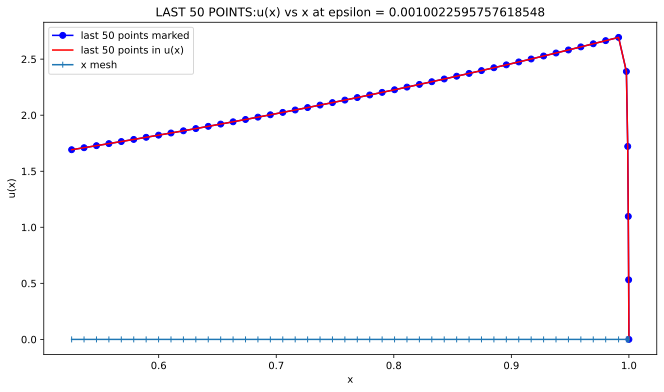



_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-


Alpha Scale =  30

_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-




Epsilon =  0.1 :  H1 error is 0.002771898156621873



Epsilon =  0.07500000000000001 :  H1 error is 0.004942583068765777



Epsilon =  0.05625000000000001 :  H1 error is 0.009138017210862734



Epsilon =  0.0421875 :  H1 error is 0.017309417663066554



Epsilon =  0.031640625000000006 :  H1 error is 0.032966298277876824



Epsilon =  0.023730468750000004 :  H1 error is 0.06228895628148971



Epsilon =  0.0177978515625 :  H1 error is 0.11612403230668218



Epsilon =  0.013348388671875001 :  H1 error is 0.21393680802968368



Epsilon =  0.01001129150390625 :  H1 error is 0.3921614511467429



Epsilon =  0.007508468627929688 :  H1 error is 0.6974402306477367



Epsilon =  0.005631351470947266 :  H1 error is 1.2153202159568868



Epsilon =  0.004223513603210449 :  H1 error is 2.2210555542447734

Epsilon =  0.0031676352024078373 :  H1 error is 4.192603894281912



Epsilon =  0.002375726401805878 :  H1 error is 8.070715663765439

Epsilon =  0.0017817948013544084 :  H1 error is 19.911790971883477



Epsilon =  0.0013363461010158064 :  H1 error is 32.64682367673983

Epsilon =  0.0010022595757618548 :  H1 error is 45.90021106741436



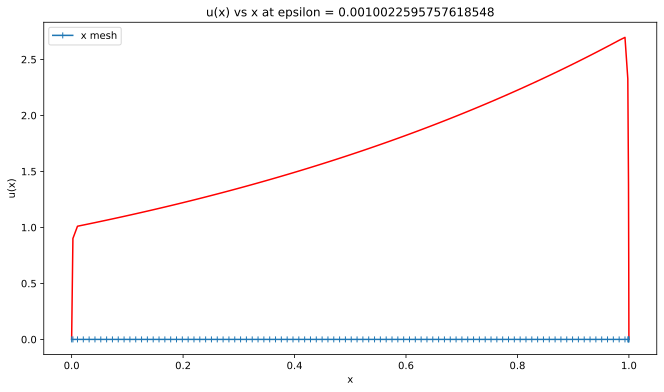

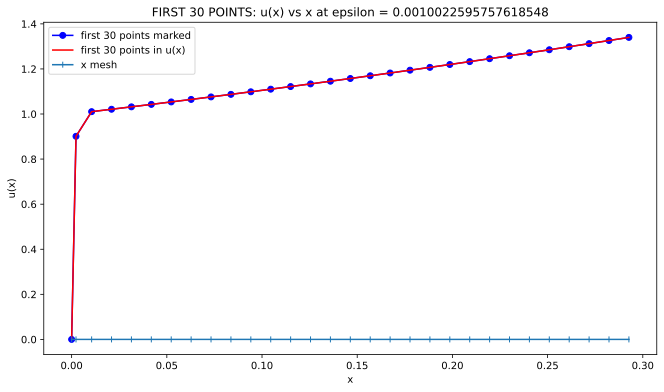

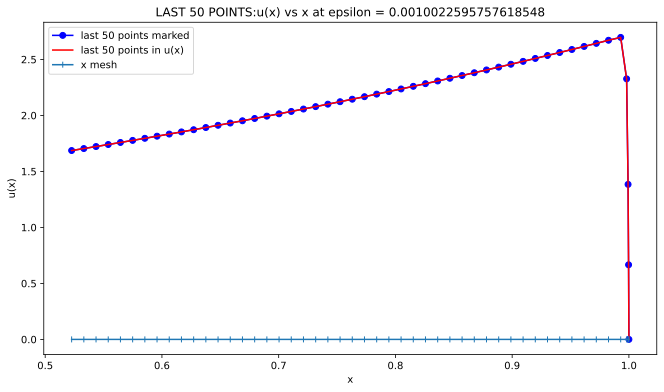



----------------------------------------------------------------------------------------------------

The H1 Error results:

----------------------------------------------------------------------------------------------------


Alpha Scale =  1
H1 Error =  3.5649646207861174

Alpha Scale =  2.5
H1 Error =  7.949591034107803

Alpha Scale =  5
H1 Error =  4.549045026349493

Alpha Scale =  7.5
H1 Error =  4.056083614813797

Alpha Scale =  10
H1 Error =  13.689273459982841

Alpha Scale =  15
H1 Error =  18.144107054984772

Alpha Scale =  20
H1 Error =  30.384920075368928

Alpha Scale =  25
H1 Error =  31.294727800661576

Alpha Scale =  30
H1 Error =  45.90021106741436



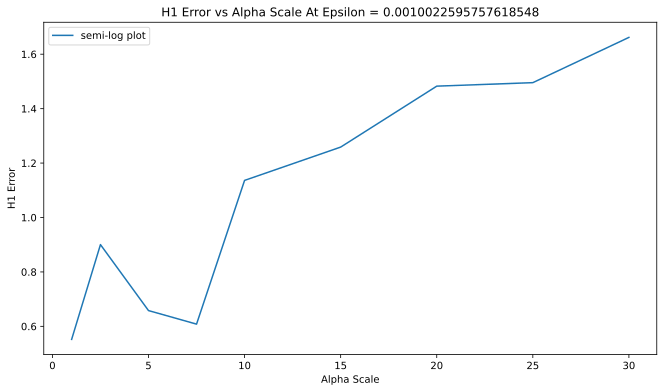

In [ ]:
# Set epsilons
epsilon = 0.1
eps_final = 1e-3
eps_change = 3/4
scales = [1, 2.5 , 5, 7.5, 10, 15, 20, 25, 30]
scale_results_H1 = []
H1_results = []
x_save = Function(V)
u_save = Function(V)

# Set H1 norm minimizing parameters
p = 2
q = 2
m = 1
exp_M = Constant( (2*q) / (1 + q*(2-m)) )
alpha_power = -5/4


# Loop over alpha scales
for alpha_scale in scales:

    print('_-'*100)
    print()
    print()
    print('Alpha Scale = ', alpha_scale)
    print()
    print('_-'*100)
    print()
    print()


    # Re-set x and epsilon at new alpha scale
    x = Function(V).interpolate(SpatialCoordinate(xi_mesh)[0])
    epsilon = 0.1



    # Epsilon continuation loop
    while epsilon >= eps_final:


        # NONLINEAR MESH SOLVE


        # set solution and test function
        new_x = Function(V)
        vm = TestFunction(V)


        # jacobian
        Jm = new_x.dx(0) #dx/dxi


        # Compute exact u
        top = (1 - exp(1 - 1/epsilon))*exp(-new_x/epsilon) + (exp(1) - exp(-1/epsilon))*exp((new_x-1)/epsilon)
        bottom = (epsilon**2 - 1) * ( 1 - exp(-2/epsilon) )
        sub = exp(new_x)/(epsilon**2 - 1)
        u_e = top/bottom - sub


        # Compute u'
        upr_f = (1/Jm) * u_e.dx(0)
        # Compute u''
        u_pr_xi = u_e.dx(0)
        u_prpr_xi = u_pr_xi.dx(0)
        x_prpr_xi = Jm.dx(0)
        u_prpr = ( u_prpr_xi -  upr_f * x_prpr_xi) * (( 1/Jm )**2)

        # Compute M
        alpha_hat = alpha_scale * epsilon ** (alpha_power) # OUR ALPHA SCALED WITH EPSILON!!
        # alpha_term1 = float(alpha_hat * sqrt(assemble(u_e*u_e* Jm * dx)))
        M = ( 1 + (1/alpha_hat) * abs(u_prpr) )**exp_M

        # v'
        v_pr_term = (vm).dx(0)

        # the lhs of the eqn
        F = (M * Jm * v_pr_term) * dx

        # bc's
        bc0 = DirichletBC(V, Constant(0), 1)
        bc1 = DirichletBC(V, Constant(1), 2)
        bcs = [bc0, bc1]


        # initial guess
        new_x.dat.data[:] = x.dat.data[:]


        # The actual solve
        try:
          solve( F == 0, new_x, bcs = bcs, solver_parameters=newton_params)
        except Exception as e:
          print('MESH SOLVE FAILED BECAUSE ', e)
          print()
          print()
          forced_break = True
          break


        # update our x
        x.dat.data[:] = new_x.dat.data[:]


        # PHYSICAL SOLVE FOR ERROR CALCULATIONS

        # Test and Trial Functions
        u = TrialFunction(V)
        v = TestFunction(V)

        # Jacobian of x
        Jx = x.dx(0) #dx/dxi

        # Set the bilinear and linear forms of the weak form
        u_deriv = (1/Jx) * u.dx(0) # transform to du/dx
        v_deriv = (1/Jx) * v.dx(0) # transform to dv/dx
        a = ((epsilon**2)* (u_deriv * v_deriv ) + inner(u, v)) * Jx * dx # transform dxi to dx
        L = ( exp(x) ) * v * Jx * dx #transform dxi to dx

        # Set the BC's
        bcs = [DirichletBC(V, Constant(0), 1), DirichletBC(V, Constant(0), 2)]

        # Solve
        try:
          u = Function(V)
          solve( a==L, u, bcs = bcs, solver_parameters = lu_params)
        except Exception as e:
          print('The physical solve failed due to the following message:')
          print(e)
          print()
          break

        # H1 ERROR CALCULATIONS
        u_pr_approx = (1/Jx) * u.dx(0)
        u_pr_exact = (1/Jx) * u_e.dx(0)
        error_val = (u_pr_approx - u_pr_exact)
        H1_error = norm(error_val * (sqrt(abs(Jx))))
        print("Epsilon = ", epsilon, ":", end = "  ")
        print("H1 error is", H1_error)
        print()


        # Update epsilon
        epsilon = epsilon * eps_change





    # Plot the exact solution
    plt.plot(new_x.dat.data[perm_x], Function(V).interpolate(u_e).dat.data[perm_x], color = "red" )
    plt.plot(new_x.dat.data[perm_x], [0 for i in range(len(new_x.dat.data[perm_x]))], marker = "|", label = "x mesh")
    plt.xlabel('x')
    plt.ylabel("u(x)")
    plt.title("u(x) vs x at epsilon = " + str(epsilon/eps_change))
    plt.legend()
    plt.show()
    print()
    print()

    # Plot the first 30 points
    plt.plot(new_x.dat.data[perm_x][:30], Function(V).interpolate(u_e).dat.data[perm_x][:30], marker = "o", color = "blue", label = 'first 30 points marked' )
    plt.plot(new_x.dat.data[perm_x][:30], Function(V).interpolate(u_e).dat.data[perm_x][:30], color = "red", label = 'first 30 points in u(x)' )
    plt.plot(new_x.dat.data[perm_x][:30], [0 for i in range(30)], marker = "|", label = "x mesh")
    plt.xlabel('x')
    plt.ylabel("u(x)")
    plt.title("FIRST 30 POINTS: u(x) vs x at epsilon = " + str(epsilon/eps_change))
    plt.legend()
    plt.show()
    print()
    print()


    # Plot the last 30 points
    plt.plot(new_x.dat.data[perm_x][-50:], Function(V).interpolate(u_e).dat.data[perm_x][-50:], marker = "o", color = "blue", label = 'last 50 points marked' )
    plt.plot(new_x.dat.data[perm_x][-50:], Function(V).interpolate(u_e).dat.data[perm_x][-50:], color = "red", label = 'last 50 points in u(x)' )
    plt.plot(new_x.dat.data[perm_x][-50:], [0 for i in range(50)], marker = "|", label = "x mesh")
    plt.xlabel('x')
    plt.ylabel("u(x)")
    plt.title("LAST 50 POINTS:u(x) vs x at epsilon = " + str(epsilon/eps_change))
    plt.legend()
    plt.show()
    print()
    print()



    # Save the results
    x_save.dat.data[:] = new_x.dat.data[:]
    u_save.dat.data[:] = Function(V).interpolate(u_e).dat.data[:]
    scale_results_H1.append([alpha_scale, x_save, u_save])
    H1_results.append(H1_error)




# Print and plot the H1 Errors

print('-'*100)
print()
print('The H1 Error results:')
print()
print('-'*100)
print()
print()

for i in range(len(scales)):

  print('Alpha Scale = ', scales[i])
  print('H1 Error = ', H1_results[i])
  print()


plt.plot(scales, np.log10(H1_results), label = "semi-log plot")
plt.xlabel('Alpha Scale')
plt.ylabel('H1 Error')
plt.title('H1 Error vs Alpha Scale At Epsilon = ' + str(epsilon/eps_change))
plt.legend()
plt.show()
print()
print()




